In [211]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

h = 6.62607004e-34 #J*s, planck constant
c = 3*1e8 #m/s', speed of light
e = 1.602e-19 #electron charge

In [212]:
def read_file(filename):
    photon_E, total_yield, yield_error = [],[],[]

    copy_lines=[]
    with open(filename) as f:
        lines = f.readlines()

    for line in lines:
        split_line = line.split()
        copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1): #2nd line in the file is the first relevant one
        line = copy_lines[i]

        photon_E.append(line[0]) #strip element name and type of commas
        total_yield.append(line[1])
        yield_error.append(line[2])

#extracted values are strings --> cast numbers to floats
    for i in range(0, len(photon_E)):
        photon_E[i] = float(photon_E[i])
        total_yield[i] = float(total_yield[i])
        yield_error[i] = float(yield_error[i])

    return([photon_E, total_yield, yield_error])

In [236]:
[ITO_MLI_1_90_E, ITO_MLI_1_90_TEY, ITO_MLI_1_90_TEY_err] = read_file('Elettra_campaign_Aug24_2021_results/ITO_MLI_1_90deg_Aug24_2021.txt')

In [237]:
def convert_nm_to_eV(nm_array):
    eV = 1.602*10e-19 #Joule, electronvolt
    h = 6.62607004*10e-34 #J*s, planck constant
    c = 2.99792*1e8 #m/s', speed of light
    eV_list = []
    for lambda_val in nm_array:
        energy_J = h*c/(lambda_val*1e-9)
        energy_eV = energy_J/eV
        eV_list.append(energy_eV) #in nm
    return(np.array(eV_list))

In [238]:
def convert_eV_to_nm(energy_eV_list):
    # a simple function that takes a list with photon energy values (in eV) and converts them into wavelength in nanometers
    eV = 1.602*1e-19 #Joule, electronvolt
    h = 6.62607004*1e-34 #J*s, planck constant
    c = 3*1e8 #m/s', speed of light
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J/(1e-9)) #in nm
    return(wavelength_list)

In [246]:
df = pd.read_csv("SORCE_solar_irradiance_1-400nm.csv")
wavelength = np.array(df["wavelength (nm)"].tolist())
irradiance = np.array(df["irradiance (W/m^2/nm)"].tolist())/1e-9 #convert nm to m
irradiance_err = np.array(df["uncertainty (W/m^2/nm)"].tolist())
df.head()

,wavelength (nm),irradiance (W/m^2/nm),uncertainty (W/m^2/nm),Unnamed: 3,Unnamed: 4
0,1.5,0.000072,0.050974,NaN,NaN
1,2.5,0.000056,0.050974,NaN,NaN
2,3.5,0.000046,0.050974,NaN,NaN
3,4.5,0.000054,0.050974,NaN,NaN
4,5.5,0.000071,0.050974,NaN,NaN


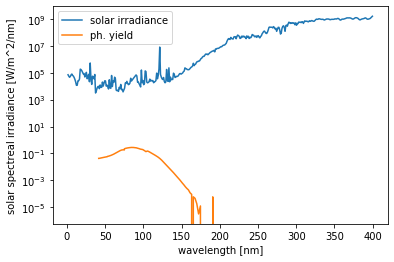

In [247]:
plt.plot(wavelength,irradiance,label='solar irradiance')
plt.plot(convert_eV_to_nm(ITO_MLI_1_90_E),ITO_MLI_1_90_TEY,label='ph. yield')
plt.yscale("log")
plt.xlabel("wavelength [nm]")
plt.ylabel("solar spectreal irradiance [W/m^2/nm]")
plt.legend()

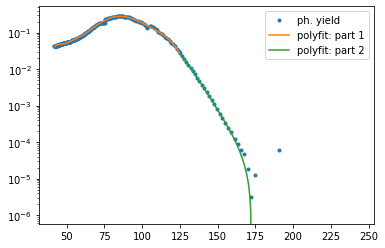

In [248]:
lambda_min = 42
lambda_thresh = 125
lambda_max = 175

x1 = np.linspace(lambda_min,lambda_thresh,100)
x2 = np.linspace(lambda_thresh,lambda_max,100)
TEY_fit_1 = np.poly1d(np.polyfit(convert_eV_to_nm(ITO_MLI_1_90_E)[40:],ITO_MLI_1_90_TEY[40:],deg=11))
TEY_fit_2 = np.poly1d(np.polyfit(convert_eV_to_nm(ITO_MLI_1_90_E)[:40],ITO_MLI_1_90_TEY[:40],deg=11))

plt.plot(convert_eV_to_nm(ITO_MLI_1_90_E),ITO_MLI_1_90_TEY,'.',label='ph. yield')
plt.plot(x1,TEY_fit_1(x1),label='polyfit: part 1')
plt.plot(x2,TEY_fit_2(x2),label='polyfit: part 2')
plt.yscale("log")
plt.legend()

In [249]:
electron_flux = []
used_lambda = []
d_lambda = 1.0 #nm
for i in range(len(wavelength)):
    lambda_val = wavelength[i]
    if lambda_val >= lambda_min and lambda_val <= lambda_max:
        if lambda_val <= lambda_thresh:
            photon_flux_val = TEY_fit_1(lambda_val)*irradiance[i]*(lambda_val*1e-9)*(d_lambda*1e-9)/(h*c)
        else:
            photon_flux_val = TEY_fit_2(lambda_val)*irradiance[i]*(lambda_val*1e-9)*(d_lambda*1e-9)/(h*c)
        electron_flux.append(photon_flux_val)
        used_lambda.append(lambda_val)

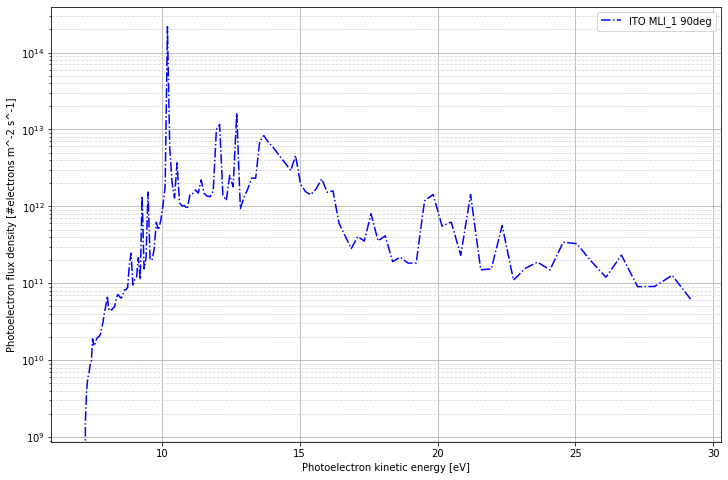

In [277]:
plt.figure(figsize=(12, 8))

plt.plot(convert_nm_to_eV(used_lambda),electron_flux,'-.',color='blue',label='ITO MLI_1 90deg')
plt.yscale("log")
plt.xlabel('Photoelectron kinetic energy [eV]')
plt.ylabel('Photoelectron flux density [#electrons m^-2 s^-1]')
plt.grid(which = 'major', linestyle='-')
plt.grid(which = 'minor', linestyle='--', color='0.85')
plt.legend()

plt.savefig('plots/MLI_1_90deg_photoelectron_flux.png', dpi=300)